# Importing Data

In [1]:
# Import libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import itertools as itt
import pickle as pk

full_train = pd.read_parquet('../data/cleaned/all_features_train.parquet')
full_test = pd.read_parquet('../data/cleaned/all_features_test.parquet')

# Defining Functions for Further Use

In [2]:
# Add columns of zeroes for each column present in X_train but not present in X_test
# Example:
# zipcode_98050 was not present in X_test and was duplicated through one-hot-encoding and engineered interactions
# Since all of these columns represent dummy variables, this should not affect modeling whatsoever
# X_test and X_train need to have the same shape for sklearn LinearRegression()
def equalize_columns(df_1, df_2):
    # Columns in df_2 but not df_1
    col_to_add_1 = [x for x in df_2.columns if x not in df_1.columns]
    
    # Columns in df_1 but not df_1
    col_to_add_2 = [x for x in df_1.columns if x not in df_2.columns]
    
    # Create columns of 0s for df_1, as needed
    if col_to_add_1 != []:
        for col in col_to_add_1:
            df_1[col] = 0
    
    # Create columns of 0s for df_2, as needed
    if col_to_add_2 != []:
        for col in col_to_add_2:
            df_2[col] = 0
            
    # Reindex df_2 so that both data frames have same column order
    df_1_col_order = df_1.columns.values.tolist()
    df_2.reindex(columns = df_1_col_order)
    
    return None

In [3]:
# Runs a linear regression fitted on train data, then predicts on test data using a specified column set
# Creates a pandas DataFrame containing the R^2 value of X_train, y_train
# as well as the R^2 value obtained from predicting on X_test using coefficients from fitting on X_train
# Also contains the fitted coefficient names/values/p-scores/confidence intervals
# Returns the y_prediction from predicting on X_test and the pandas DataFrame with tabular information
def run_linear_regression(X_train, y_train, X_test, y_test, column_subset):
    # Fit on training data
    lr = LinearRegression()
    lr.fit(X_train[column_subset], y_train)
    lr_sm = sm.OLS(y_train, sm.add_constant(X_train[column_subset])).fit()
    
    # Extract test and train R^2 values, as well as parameter names and coefficients, write to pandas DataFrame
    regression_frame = pd.concat([pd.DataFrame(zip(['Test R^2'], [lr.score(X_test[column_subset], y_test)])),
                                  pd.DataFrame(zip(['Train R^2'], [lr_sm.rsquared])),
                                  lr_sm.params.reset_index().rename(columns = {'index': 0, 0: 1})])
    
    # Extract p_values and 95% confidence intervals for coefficients
    regression_frame['p_values'] = [None, None] + lr_sm.pvalues.values.tolist()
    regression_frame['conf_int'] = [None, None] + lr_sm.conf_int(0.05).values.tolist()
    regression_frame.columns = ['param', 'coeff', 'p_values', 'conf_int']
    
    # Capture predicted values from model given test data
    y_pred = lr.predict(X_test[column_subset])
    
    return y_pred, regression_frame

In [4]:
# Checks if any string in a given list is a substring of given string
def substring_from_list_in_string(list_one, test_string):
    for string in list_one:
        if string in test_string:
            return True
        
    return False

In [5]:
# Cleans an array of symmetric interaction terms (a_x_b vs. b_x_a) and returns only unique features
def get_unique_interactions(features):
    features_unique = []
    
    for feature in features:
        # For each feature in feature list, if feature already present, skip (avoids duplicates)
        if feature in features_unique:
            continue
        # If not an interaction, append to feature list
        if '_x_' not in feature:
            features_unique.append(feature)
        # If _x_ in feature, then feature is an interaction, reverse the feature and check if already present
        # If not, append feature, else, skip
        else:
            split_feature = feature.split('_x_')
            split_feature.reverse()
            rejoined_feature = '_x_'.join(split_feature)
            if rejoined_feature in features_unique:
                continue
            else:
                features_unique.append(feature)
            
    return features_unique

In [6]:
# Creates a seaborn scatterplot comparing predicted versus observed values with prediction line
def plot_residuals(y_pred, y_test, ax = None):
    # Declare fig, ax objects
    if ax is None:
        fig, ax = plt.subplots(figsize = (8,8))
    
    # Create seaborn scatterplot
    sns.scatterplot(x = y_pred, y = y_test, ax = ax);
    
    # Draw line y = x to show where equality between prediction and actual should be
    ax.axline([0, 0], [1, 1], linestyle = '--', linewidth = 2, c = 'k');

    return None

# Processing Test and Train Data

In [7]:
# Split test and train data sets into X, y_norm, and y_log
X_train, y_train_norm, y_train_log = (full_train.drop(['price', 'log(price_plus_0)'], axis = 1),
                                      full_train.price,
                                      full_train['log(price_plus_0)'])
X_test, y_test_norm, y_test_log = (full_test.drop(['price', 'log(price_plus_0)'], axis = 1),
                                      full_test.price,
                                      full_test['log(price_plus_0)'])

# Equalize X_test and X_train
equalize_columns(X_train, X_test)

# Defining Categories of Columns to Customize Models

In [8]:
# Defining base categories for further selection use
binaries = ['waterfront', 'greenbelt', 'nuisance']
ordinals = ['view', 'condition', 'grade']
discrete = ['bedrooms', 'bathrooms', 'floors', 'yr_built']

# Selects based on substring, avoids interactions
continuous = [x for x in X_train.columns if 'sqft' in x and '_x_' not in x and 'log' not in x]
zipcodes = [x for x in X_train.columns if 'zip' in x and '_x_' not in x]
log_continuous = [x for x in X_train.columns if 'log' in x and '_x_' not in x]

# Searches for '_' since ordinal columns do not have '_' but one-hot encoded columns do
ordinal_ohes = [x for x in X_train.columns if ('view' in x or 'condition' in x or 'grade' in x)\
                and '_' in x and '_x_' not in x]

# Searches for '_' and checks that feature not already assigned to a category
ohes = [x for x in X_train.columns if '_' in x and '_x_' not in x\
        and x not in set(itt.chain(binaries, ordinals, discrete, continuous,\
                                   log_continuous, zipcodes, ordinal_ohes))]

# Captures all interactions
interactions = [x for x in X_train.columns if '_x_' in x]

In [9]:
# Testing that the shape and values of base categories matches all column values in X_train
# In other words, the above lists partition all of X_train
print(len(X_train.columns.values) == len(set(binaries + ordinals + discrete\
                                             + continuous + zipcodes + log_continuous\
                                             + ordinal_ohes + ohes + interactions)),
      set(X_train.columns.values) == set(binaries + ordinals + discrete\
                                         + continuous + zipcodes + log_continuous\
                                         + ordinal_ohes + ohes + interactions),
      sep = '\n')

True
True


# Defining Groups of Categories to Use for Modeling

In [10]:
# Create groups representing various base categories to test with
baseline_columns = binaries + ordinals + discrete + continuous + zipcodes + ohes
baseline_log_cont = binaries + ordinals + discrete + log_continuous + zipcodes + ohes
baseline_ordohe = discrete + continuous + binaries + ordinal_ohes + ohes + zipcodes
log_base_ordohe = discrete + log_continuous + binaries + ordinal_ohes + ohes + zipcodes
ordinals_not_grade = [x for x in ordinals if 'grade' not in x]
ordinals_ohe_not_grade = [x for x in ordinal_ohes if 'grade' not in x]
binaries_and_continuous = binaries + continuous
cont_and_disc = continuous + discrete

In [11]:
# Create categories based off 'primary' sqft categories: sqft_living and sqft_lot
# Other sqft categories are likely correlated and could lead to collinearity issues if included 
primary_sqft = ['sqft_living', 'sqft_lot']
primary_log_sqft = [x for x in log_continuous if substring_from_list_in_string(primary_sqft, x)]
log_continuous_not_primary = [x for x in log_continuous if x not in primary_log_sqft]
primary_base = binaries + ordinals + discrete + primary_sqft + zipcodes + ohes
log_primary_base = binaries + ordinals + discrete + primary_log_sqft + zipcodes + ohes
prim_and_disc = primary_sqft + discrete
log_prim_and_disc = primary_log_sqft + discrete

# Simple Linear Regression and Baseline Multilinear Regressions

       param     coeff  p_values conf_int
0   Test R^2  0.443392       NaN     None
0  Train R^2  0.420277       NaN     None


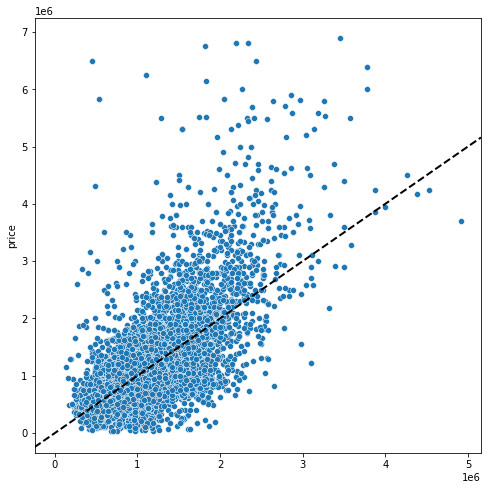

In [12]:
# Simple linear regression on highest correlated column - sqft_living
# Test R^2 of 0.4434 is not very strong
simple_columns = ['sqft_living']
y_pred, df = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, simple_columns)

print(df.iloc[:2])

plot_residuals(y_pred, y_test_norm)

       param     coeff  p_values conf_int
0   Test R^2  0.751223       NaN     None
0  Train R^2  0.757472       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.726913       NaN     None
0  Train R^2  0.719369       NaN     None


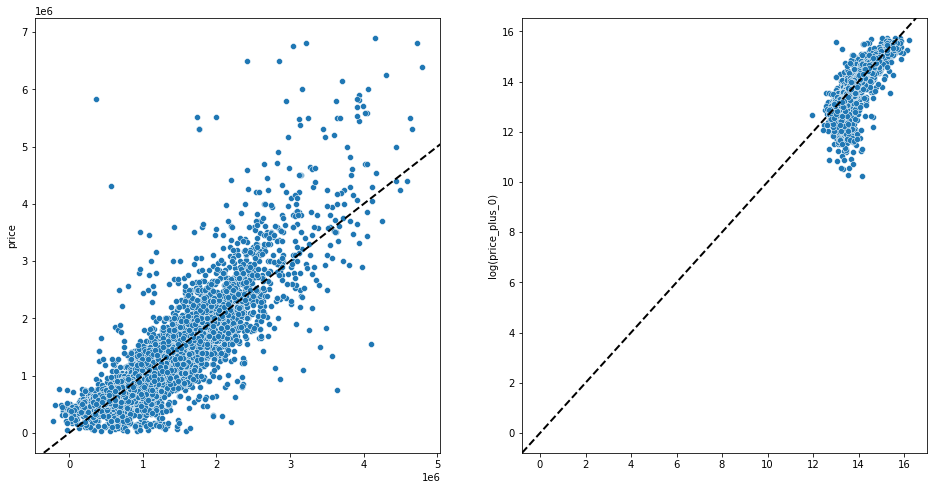

In [13]:
# Create multi-linear regression baseline using all of the base categories
# Except: continuous variables not log transformed and ordinal variables encoded ordinally instead of as ohe
# Much better Test R^2: 0.7512
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, baseline_columns)

# Test baseline regression using log-transformed y (price)
# Test R^2 slightly worse, 0.7269
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, baseline_columns)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])

# Write y_pred_norm and df_norm to pickle objects for use in visualizations
with open('../data/cleaned/baseline_regression_y_pred.pickle', 'wb') as f:
    pk.dump(y_pred_norm, f)
with open('../data/cleaned/baseline_regression_coeff_frame.pickle', 'wb') as f:
    pk.dump(df_norm, f)

       param     coeff  p_values conf_int
0   Test R^2  0.729757       NaN     None
0  Train R^2  0.736595       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.728624       NaN     None
0  Train R^2  0.720479       NaN     None


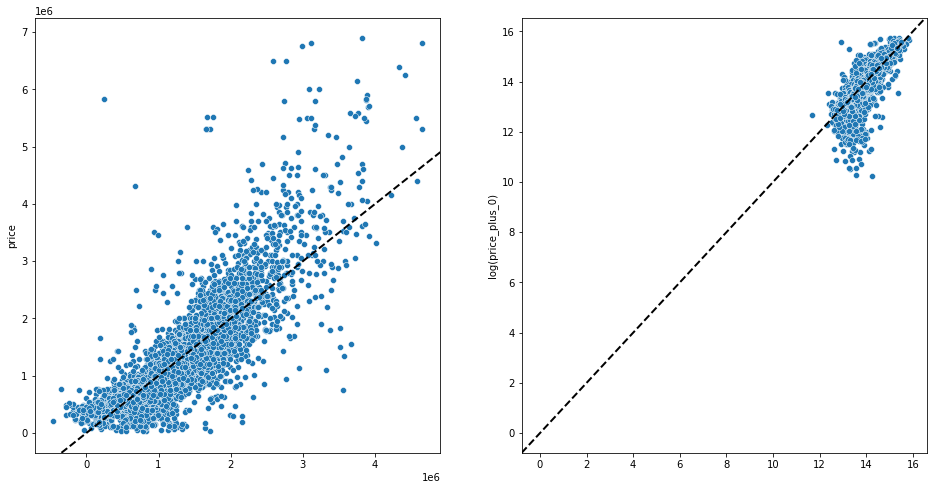

In [14]:
# Test variation of baseline regression using log-transformed continuous variables
# Test R^2 against norm y: 0.7298, Test R^2 against log y: 0.7286, roughly equal but worse than baseline
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, baseline_log_cont)
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, baseline_log_cont)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])

# Test One-Hot Encoded Instead of Ordinal

       param     coeff  p_values conf_int
0   Test R^2  0.753132       NaN     None
0  Train R^2  0.761993       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.727410       NaN     None
0  Train R^2  0.720576       NaN     None


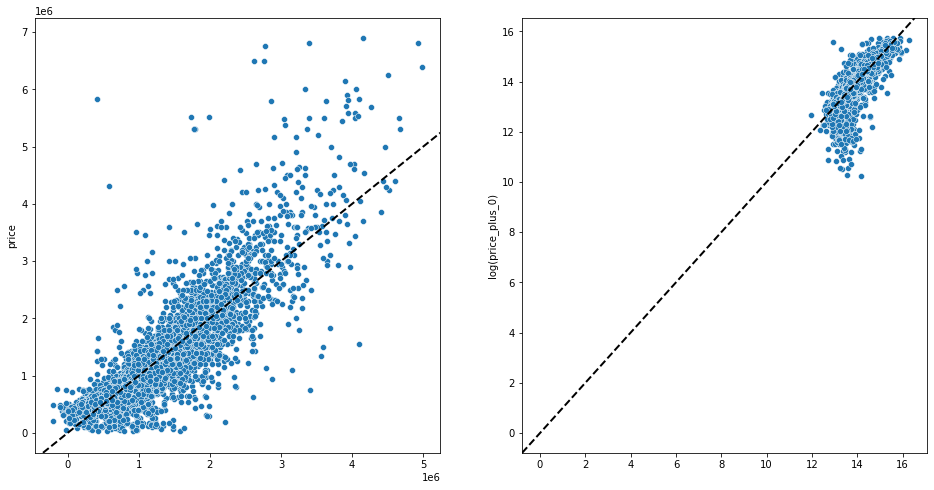

In [15]:
# Test converting all ordinal columns except for grade to one-hot-encoded columns
# Performance not greatly improved over baseline model
X_col = list(set(baseline_columns) - set(ordinals_not_grade)) + ordinals_ohe_not_grade
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])

       param     coeff  p_values conf_int
0   Test R^2  0.732101       NaN     None
0  Train R^2  0.741420       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.729217       NaN     None
0  Train R^2  0.721780       NaN     None


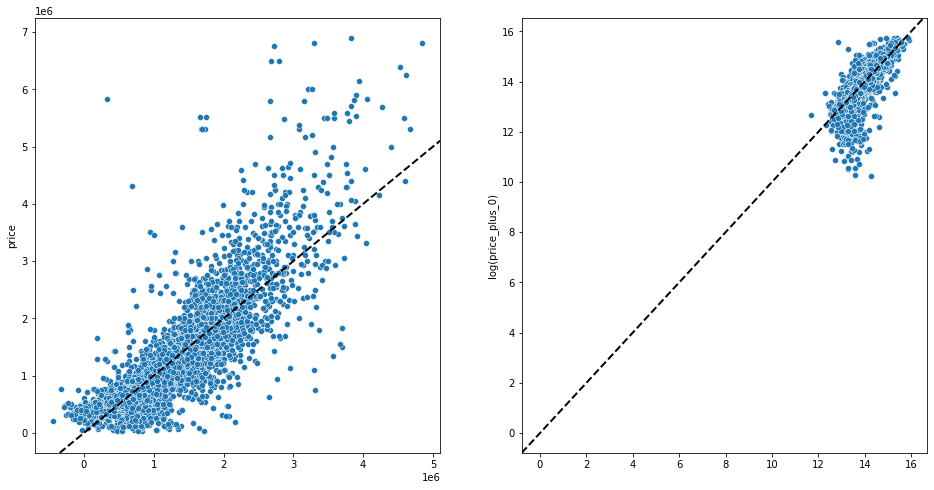

In [16]:
# Same test as above but with log-transformed continuous variables
# Worse performance than normal continuous variables
X_col = list(set(baseline_log_cont) - set(ordinals_not_grade)) + ordinals_ohe_not_grade
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])

# Test Zip Code Interactions

       param     coeff  p_values conf_int
0   Test R^2  0.788337       NaN     None
0  Train R^2  0.824724       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.727210       NaN     None
0  Train R^2  0.742562       NaN     None


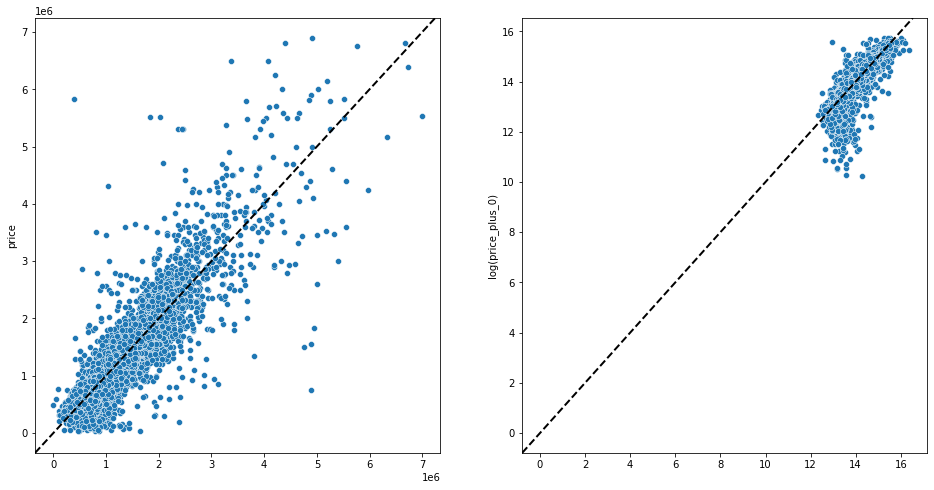

In [17]:
# Zip code appeared to greatly affect all other independent variabels during EDA
# Test using zip interaction columns between binary and continuous variables
# Test R^2 against y norm: 0.7883, an improvement over the baseline model
# Test R^2 against y log has consistently performed worse compared to y norm
# This is surprising considering initial analysis

# Selects interactions with zip codes and features from from binaries or continuous but not containing log
zip_interactions_bc = [x for x in interactions if substring_from_list_in_string(binaries_and_continuous, x)\
                       and substring_from_list_in_string(zipcodes, x) and 'log' not in x]

X_col = baseline_columns + zip_interactions_bc
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])

       param     coeff  p_values conf_int
0   Test R^2  0.784441       NaN     None
0  Train R^2  0.849847       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.715710       NaN     None
0  Train R^2  0.767399       NaN     None


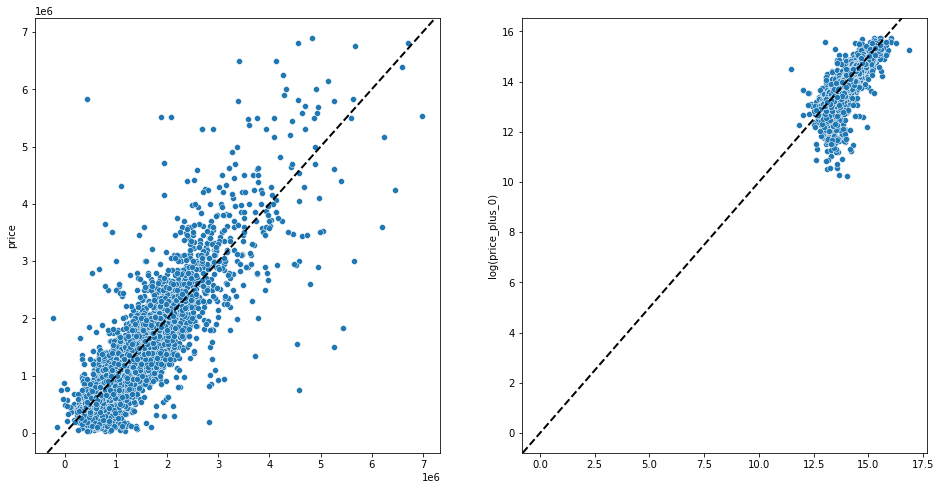

In [18]:
# Test using all zipcode interactions with baseline variables
# Test R^2 of 0.7844, better than baseline, but worse than just zip code interactions on binary or continous

# Selects interactions with zip codes and features from baseline columns but not ordinal_ohes or containing log
zipcode_interactions_baseline = [x for x in interactions if substring_from_list_in_string(baseline_columns, x)\
                                 and substring_from_list_in_string(zipcodes, x)\
                                 and not substring_from_list_in_string(ordinal_ohes, x) and 'log' not in x]

X_col = get_unique_interactions(baseline_columns + zipcode_interactions_baseline)
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])

       param     coeff  p_values conf_int
0   Test R^2  0.789665       NaN     None
0  Train R^2  0.847317       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.717777       NaN     None
0  Train R^2  0.763201       NaN     None


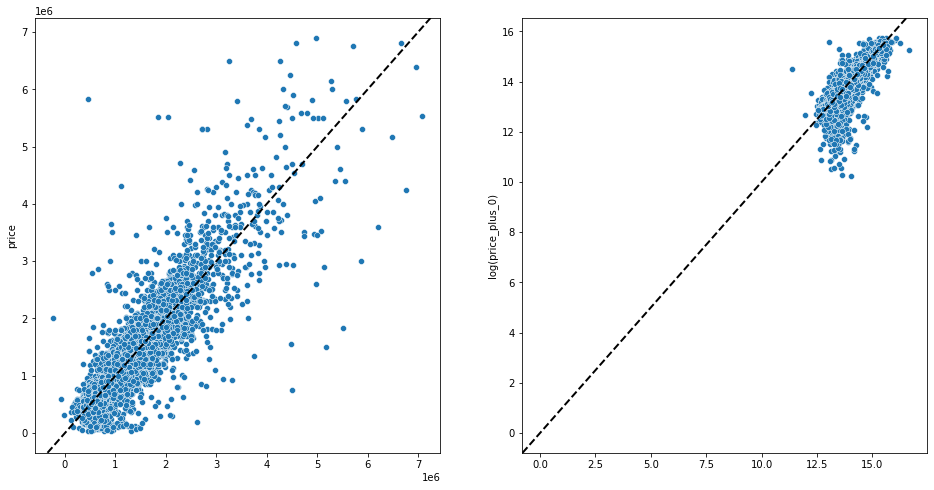

In [19]:
# Test using one-hot encoding for ordinal variables
# Test R^2 = 0.7900, slight improvement over ordinally encoded variables

# Selects interactions with zip codes and features from baseline_ordohe but not ordinals or containing log
zipcode_interactions_baseline_ordohe = [x for x in interactions if substring_from_list_in_string(baseline_ordohe, x)\
                                        and substring_from_list_in_string(zipcodes, x)\
                                        and not substring_from_list_in_string(ordinals, x) and 'log' not in x]

X_col = get_unique_interactions(baseline_ordohe + zipcode_interactions_baseline_ordohe)
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])

       param     coeff  p_values conf_int
0   Test R^2  0.790791       NaN     None
0  Train R^2  0.848229       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.720210       NaN     None
0  Train R^2  0.765258       NaN     None


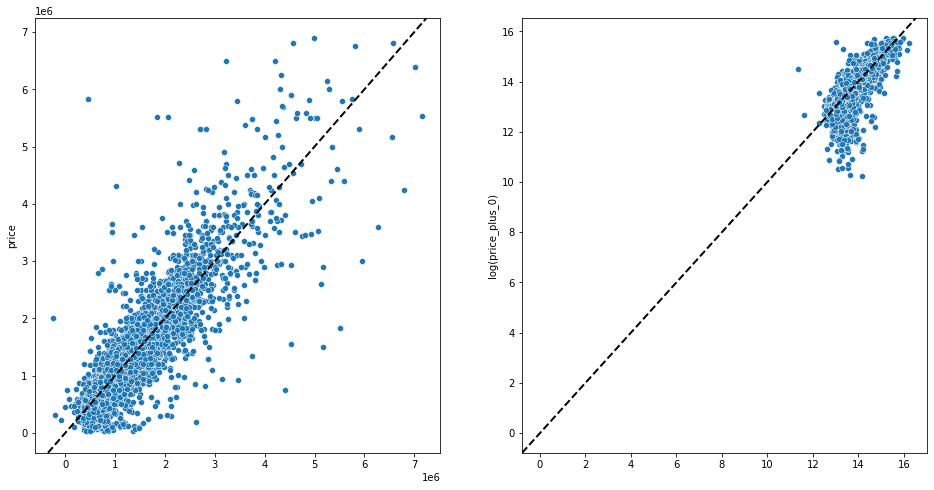

In [20]:
# Same test as above but with log-transformed continuous variables
# Test R^2 = 0.7908, slightly better than normal continuous variables

# Selects interactions with zip codes and features from log_baseline_ordohe but not ordinals or containing log
zipcode_interactions_log_base_ordohe = [x for x in interactions if substring_from_list_in_string(log_base_ordohe, x)\
                                        and substring_from_list_in_string(zipcodes, x)\
                                        and not substring_from_list_in_string(ordinals, x) and 'log' not in x]

X_col = get_unique_interactions(log_base_ordohe + zipcode_interactions_log_base_ordohe)
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])

# Test Interactions with Continuous and Discrete Variables

       param     coeff  p_values conf_int
0   Test R^2  0.795226       NaN     None
0  Train R^2  0.831509       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.710248       NaN     None
0  Train R^2  0.753684       NaN     None


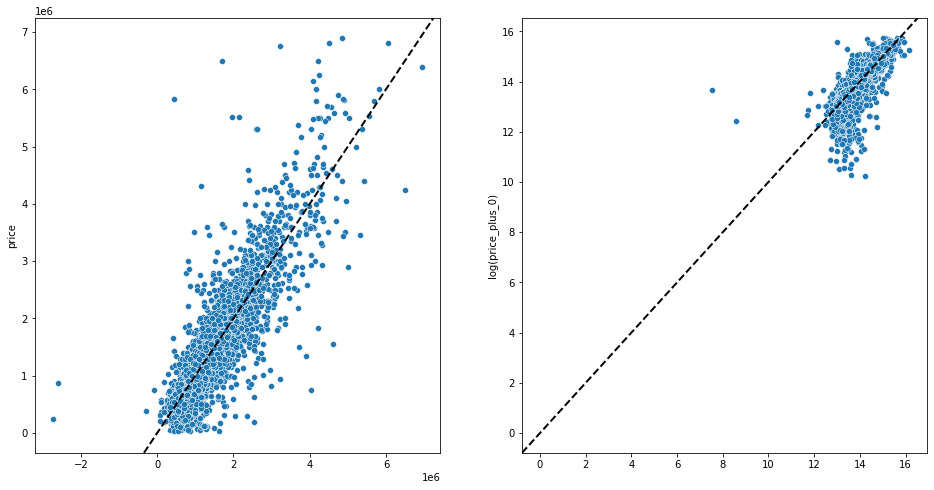

In [21]:
# Try looking at numerical interactions containing at least one continuous or discrete feature
# This includes zipcode interactions involving continuous or discrete features
# Test R^2 on norm y: 0.7952, an improvement on all prior models!

# Selects interactions with features from continuous or discrete but not ordinal_ohes or containing log
interactions_cont_disc = [x for x in interactions if substring_from_list_in_string(cont_and_disc, x)\
                          and not substring_from_list_in_string(ordinal_ohes, x) and 'log' not in x]

X_col = get_unique_interactions(baseline_columns + interactions_cont_disc)
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])

       param     coeff  p_values conf_int
0   Test R^2  0.801962       NaN     None
0  Train R^2  0.822836       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.733324       NaN     None
0  Train R^2  0.745319       NaN     None


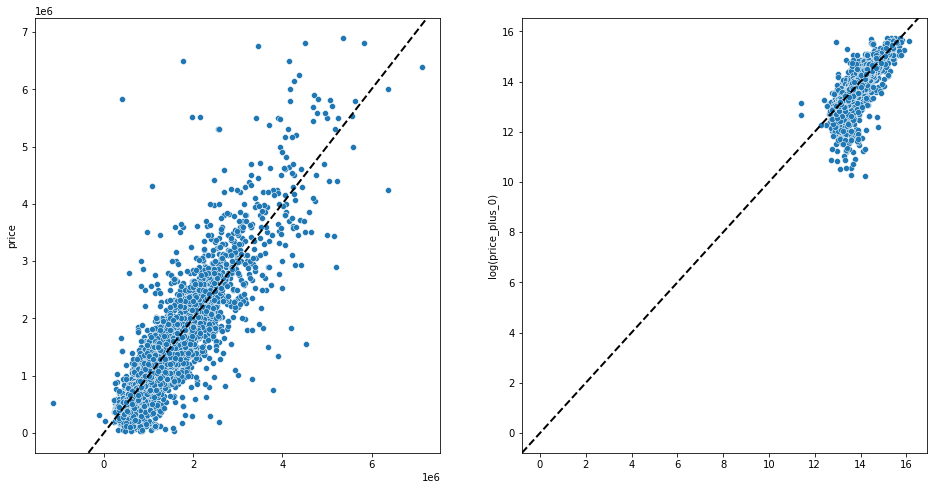

In [22]:
# Look at primary base with interactions containing at least one feature from primary_sqft or discrete
# Test R^2 = 0.8020, best result so far

# Selects interactions with features from primary_sqft or disc, but not ordinal_ohes or containing log
interactions_prim_disc = [x for x in interactions if substring_from_list_in_string(prim_and_disc, x)\
                          and not substring_from_list_in_string(ordinal_ohes, x) and 'log' not in x]

X_col = get_unique_interactions(primary_base + interactions_prim_disc)
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])

# Write y_pred_norm and df_norm to pickle objects for use in visualizations
with open('../data/cleaned/primary_discrete_interactions_y_pred.pickle', 'wb') as f:
    pk.dump(y_pred_norm, f)
with open('../data/cleaned/primary_discrete_interactions_regression_coeff_frame.pickle', 'wb') as f:
    pk.dump(df_norm, f)

In [23]:
# Examine features used for best performing model
X_col

['waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'condition',
 'grade',
 'bedrooms',
 'bathrooms',
 'floors',
 'yr_built',
 'sqft_living',
 'sqft_lot',
 'zipcode_98001',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98045',
 'zipcode_98047',
 'zipcode_98050',
 'zipcode_98051',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98057',
 'zipcode_98058',
 'zipcode_98059',
 'zipcode_98065',
 'zipcode_98070',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98075',
 'zipcode_98077',
 'zipcode_98092',
 'zipcode_98102',
 'zipcode_98103',
 'zipcode_98105',

       param     coeff  p_values conf_int
0   Test R^2  0.798162       NaN     None
0  Train R^2  0.816124       NaN     None

       param     coeff  p_values conf_int
0   Test R^2  0.736584       NaN     None
0  Train R^2  0.745735       NaN     None


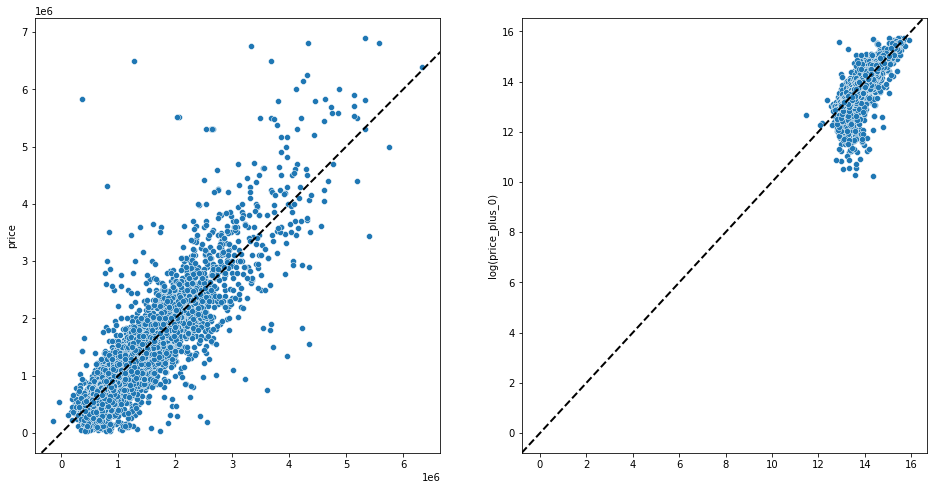

In [24]:
# Try the same as above but using log-transformed variables
# Test R^2 = 0.7982, not bad, but not better than previous

# Select interactions containing features from primary_log_sqft but not ordinal_ohes
interactions_log = [x for x in interactions if substring_from_list_in_string(primary_log_sqft, x)\
                    and not substring_from_list_in_string(ordinal_ohes, x)]

# Select interactions with features from discrete but not ordinal_ohes, continuous, or log_continuous_not primary
interactions_disc = [x for x in interactions if substring_from_list_in_string(discrete, x)\
                     and not substring_from_list_in_string(ordinal_ohes, x)\
                     and not substring_from_list_in_string(continuous, x)\
                     and not substring_from_list_in_string(log_continuous_not_primary, x)]

X_col = get_unique_interactions(log_primary_base + interactions_log + interactions_disc)
y_pred_norm, df_norm = run_linear_regression(X_train, y_train_norm, X_test, y_test_norm, X_col)
y_pred_log, df_log = run_linear_regression(X_train, y_train_log, X_test, y_test_log, X_col)

print(df_norm.iloc[:2], df_log.iloc[:2], sep = '\n\n')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plot_residuals(y_pred_norm, y_test_norm, ax = ax[0])
plot_residuals(y_pred_log, y_test_log, ax = ax[1])